In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import keras
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

import seaborn as sns

In [2]:
covid_data = pd.read_csv("./Final_Covid_Data_Updated.csv")
covid_data.head()

,County,State,Positive_Cases,Deaths,Elderly_pop,Young_pop,WHITE,NON_WHITE,NUM_STAFFED_BEDS,NUM_ICU_BEDS,...,max_temp,mean_temp,wind_speed,precipitation,station_pressure,dewpoint,Positive_Case_Rate_NORM,Death_Rate_NORM,cluster_3,cluster_5
0,Abbeville,South Carolina,662,15,5483,19044,17223,7304,25,6,...,90.758065,69.976355,4.677007,0.167563,898.098646,62.160340,0.394896,0.245653,2,3
1,Acadia,Louisiana,3004,99,9796,52249,49435,12610,144,7,...,92.632258,77.037696,5.333303,0.190817,13.352873,67.284608,1.805767,1.881842,3,5
2,Accomack,Virginia,1188,19,7934,24382,21899,10417,46,10,...,89.606452,67.919534,6.623371,0.075634,19.100712,54.542831,1.038328,0.206368,2,3
3,Ada,Idaho,13886,153,71958,409629,442550,39037,1240,97,...,94.567742,63.664768,6.399353,0.041102,914.363960,37.794472,0.516267,-0.242972,2,3
4,Adair,Iowa,85,1,1648,5504,6966,186,25,4,...,86.000000,62.290353,8.698955,0.095547,968.789048,54.676341,-0.599813,-0.538734,1,4


In [3]:
random.seed(42)
ind_shuffle = random.sample(range(len(covid_data)), len(covid_data))
covid_data_shuffled = covid_data.iloc[ind_shuffle,:]
X_DF = covid_data_shuffled.iloc[:,2:-2].drop(columns=["Positive_Case_Rate", "Positive_Case_Rate_NORM",
                                                      "Death_Rate_NORM", "Death_Rate", "Positive_Cases", "Deaths"])

In [4]:
X_DF=X_DF.drop(columns=["Elderly_pop", "Young_pop", "WHITE", "NON_WHITE",
                        "NUM_STAFFED_BEDS", "min_temp", "max_temp", "lat",
                        "dewpoint","twentieth_percentile_income", "POP_TOTAL"])

In [5]:
X = np.array(X_DF)
X = StandardScaler().fit_transform(X)
y_3 = covid_data_shuffled["cluster_3"]
y_5 = covid_data_shuffled["cluster_5"]

In [6]:
X_train = X[:int(0.9*len(X))]
X_test = X[int(0.9*len(X)):]
y_3_train = y_3[:int(0.9*len(X))]
y_3_test = y_3[int(0.9*len(X)):]
y_5_train = y_5[:int(0.9*len(X))]
y_5_test = y_5[int(0.9*len(X)):]

In [8]:
SVM_Grid_Params = {"kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
                  "gamma" : ['scale', 'auto'],
                  "decision_function_shape": ['ovo', 'ovr']}
SVM_GRID_CLF = GridSearchCV(SVC(),
                            SVM_Grid_Params,
                            verbose = 1,
                            cv = 20,
                            n_jobs = -1)

In [9]:
SVM_GRID_RS_Y3 = SVM_GRID_CLF.fit(X_train,y_3_train)
print(SVM_GRID_RS_Y3.best_params_)

Fitting 20 folds for each of 16 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   16.6s finished


{'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}


In [10]:
BEST_SVM_CLF_Y3 = SVC(decision_function_shape = 'ovo', gamma = "scale", kernel = "rbf")
BEST_SVM_CLF_Y3.fit(X_train, y_3_train)
print("Train Accuracy:", BEST_SVM_CLF_Y3.score(X_train,y_3_train))
print("Test Accuracy:", BEST_SVM_CLF_Y3.score(X_test,y_3_test))

Train Accuracy: 0.7618033368832091
Test Accuracy: 0.7261146496815286


Feature: 0, Score: 0.00234
Feature: 1, Score: 0.00511
Feature: 2, Score: 0.00788
Feature: 3, Score: 0.01093
Feature: 4, Score: 0.01328
Feature: 5, Score: 0.01647
Feature: 6, Score: 0.01683
Feature: 7, Score: 0.01747
Feature: 8, Score: 0.01754
Feature: 9, Score: 0.01853
Feature: 10, Score: 0.02513
Feature: 11, Score: 0.02670
Feature: 12, Score: 0.03663
Feature: 13, Score: 0.04352
Feature: 14, Score: 0.05098


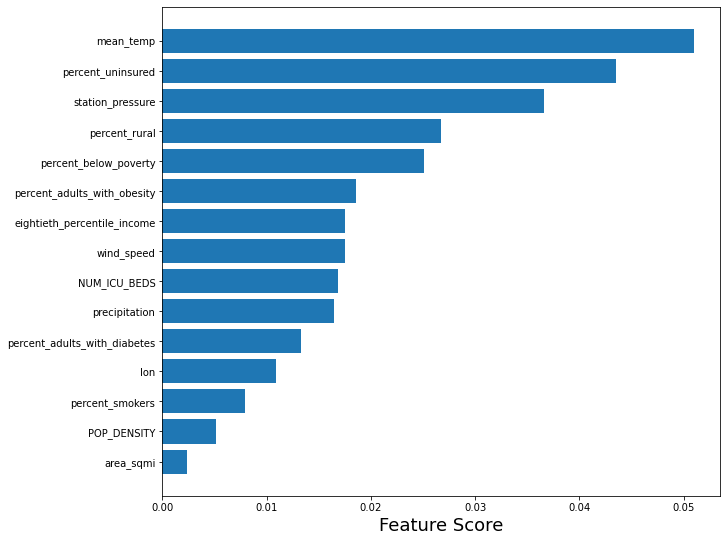

In [11]:
# perform permutation importance
results = permutation_importance(BEST_SVM_CLF_Y3, X_train, y_3_train, scoring='accuracy')
# get importance
importance = results.importances_mean
ind_sorted=np.argsort(importance)
importance_sorted = np.array(sorted(importance))
# summarize feature importance
for i,v in enumerate(importance_sorted):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(10,9))
plt.barh([x for x in range(len(importance_sorted))], importance_sorted)
plt.yticks(np.arange(len(importance_sorted)), X_DF.columns[ind_sorted],rotation='horizontal')
plt.xlabel("Feature Score", fontsize=18)
plt.show()

In [12]:
SVM_GRID_RS_Y5 = SVM_GRID_CLF.fit(X_train,y_5_train)
print(SVM_GRID_RS_Y5.best_params_)

Fitting 20 folds for each of 16 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   16.7s finished


{'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}


In [13]:
BEST_SVM_CLF_Y5 = SVC(decision_function_shape = 'ovo', gamma = "scale", kernel = "rbf")
BEST_SVM_CLF_Y5.fit(X_train, y_5_train)
print(BEST_SVM_CLF_Y5.score(X_test,y_5_test))

0.6687898089171974


Feature: 0, Score: 0.00298
Feature: 1, Score: 0.00334
Feature: 2, Score: 0.01399
Feature: 3, Score: 0.01619
Feature: 4, Score: 0.01754
Feature: 5, Score: 0.01803
Feature: 6, Score: 0.01952
Feature: 7, Score: 0.02002
Feature: 8, Score: 0.02293
Feature: 9, Score: 0.02457
Feature: 10, Score: 0.02840
Feature: 11, Score: 0.03692
Feature: 12, Score: 0.03749
Feature: 13, Score: 0.04594
Feature: 14, Score: 0.05793


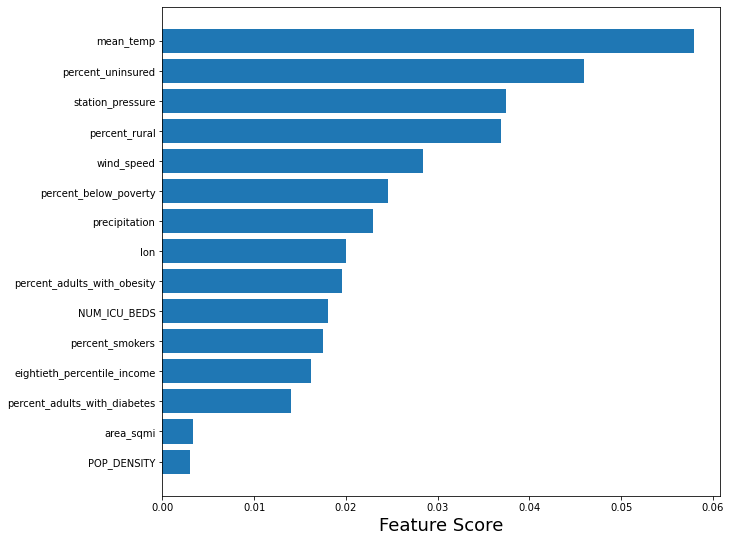

In [14]:
# perform permutation importance
results = permutation_importance(BEST_SVM_CLF_Y5, X_train, y_5_train, scoring='accuracy')
# get importance
importance = results.importances_mean
ind_sorted=np.argsort(importance)
importance_sorted = np.array(sorted(importance))
# summarize feature importance
for i,v in enumerate(importance_sorted):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(10,9))
plt.barh([x for x in range(len(importance_sorted))], importance_sorted)
plt.yticks(np.arange(len(importance_sorted)), X_DF.columns[ind_sorted],rotation='horizontal')
plt.xlabel("Feature Score", fontsize=18)
plt.show()